<a href="https://colab.research.google.com/github/NombuleloShongwe/1.Buttons-C-/blob/master/SATACS_ML_2024_%7C_Lecture_2_Example_Notebook_Naive_Bayes_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SATACS-ML 2024, Lecture 2
## Example Notebook: Implementing and Training a Gaussian Naïve Bayes Classifier

**Name:** Alyssa Amod

**Date:** 08/08/2024


---



## Problem Description

In this example notebook, we are going to implement and fit a Gaussian Naïve Bayes classifier to the Iris dataset, which consists of data corresponding to features (e.g. petal length) of different sub-species of the Iris flower family. We will go through the following steps:

1. Import the libraries/functions you'll need
2. Load the data
3. Exploratory data analysis
4. Implementing the model (a Gaussian Naïve Bayes Classifier in our case)
5. Feature selection & splitting the data into train/test sets
6. Fitting and evaluating the model
7. Plot decision regions determined by the classifier over the train/test sets

## Import the libraries you need

Typically, the first bit of code you'll write in a python notebook or script is the import statements for each of the modules/functions you will need to use when writing your program.

***A side note on coding style:*** it is standard practice to write your import statements in alphabetical order, as I've done below.
- I would recommend taking a look at the PEP-8 style guide for writing python code (https://peps.python.org/pep-0008/) which goes into a lot more detail on how to write neat, readable python code in general.
- If you don't have much experience coding, then learning how to write neat, readable code is something worth investing time in; it makes it easier for others to understand your code and collaborate with you (which will happen in most jobs involving programming, as well as most academic settings).
- Additionally, you will also make it easier for yourself when you come back to your own code at a later date and need to remember what you were doing!

As I'd mentioned in the `#tech-help` channel on Slack, we will be using data science & ML python libraries which are widely used in both industry and academia. Below, I've given a short description of each along with a link to the official documentation:

*   **NumPy** (https://numpy.org/doc/) is a python library which is typically used to handle datasets in-memory in the form of matrices and vectors, used for performing highly efficient linear algebra operations. NumPy is arguable the most fundemental library in the field of applied machine learning, as all the libraries we will use and at the very least NumPy compatible, or designed specifically to work with NumPy data-types.  
*   **Matplotlib** (https://matplotlib.org/stable/contents.html#) is a python library used for both static (ie plots) and dynamic (ie animations) data visualisation. Plotting functions in Matplotlib typically expect the input data to be stored in a NumPy array/matrix (although it will also accept python lists in most cases).  
*   **Pandas** (https://pandas.pydata.org/docs/) is a great python library which allows for highly effective management, manipulation and visulation of data through their `DataFrame` data structure object. You can think of Pandas as an extension of the NumPy library, as Pandas `DataFrames` work exclusively with NumPy arrays as the core data structure.  
*   **Scikit-Learn** (https://scikit-learn.org/stable/) is a machine learning library written in python; it has implementations of all of the algoirthms we will be learining about in the first half of the course (however, in this notebook I am only using Scikit-Learn to load a toy dataset)

**Note that while you will often find answers to your coding problems by Googling (e.g., on https://stackoverflow.com/ or ChatGPT), the best place to find answers to your questions, and to understand the tools you will be working with, is to read the official documentation.**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

## Load the data you're going to work with

There are several ways to import data into a notebook; more often than not, you will be loading data directly from a file (eg .CSV, .XLSX) or a database (eg using a SQL query). In this example however, I am going to load a toy dataset called [the Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) which is a multivariate dataset containing data corresponding to a number of sub-species of the Iris flower (Iris setosa, Iris versicolor and Iris virginica). The features include: sepal length, sepal width, petal length and petal width.

First I will load the dataset from Scikit-learn's `datasets` library, and then concatenate the feature (`iris.data`) and label (`iris.target`) data (both of which are NumPy arrays) into a single 2-D NumPy array, and loading the data into a Pandas DataFrame object so I can view a small sample of it in a neat table, using `df.sample(5)` (see below).

In [ ]:
# Load the Iris dataset & view the data using pandas
iris = datasets.load_iris()
data = np.column_stack((iris.data, iris.target)) # concatenate features and labels
df = pd.DataFrame(
    data=data,
    columns = iris.feature_names + ['label (species)'] # column names
)
df['species name'] = df['label (species)'].map({
    0: iris.target_names[0],
    1: iris.target_names[1],
    2: iris.target_names[2],
})

df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label (species),species name
124,6.7,3.3,5.7,2.1,2.0,virginica
91,6.1,3.0,4.6,1.4,1.0,versicolor
36,5.5,3.5,1.3,0.2,0.0,setosa
99,5.7,2.8,4.1,1.3,1.0,versicolor
131,7.9,3.8,6.4,2.0,2.0,virginica


## Exploratory data analysis

Typically, the next thing you are going to do is to perform some exploratory data analysis. Some of the questions you'll want to answer are:



*   Are the any missing or corrupted data points in the dataset?
*   What are the data types of each of the variables in the data (ie real valued data, catagorical data, strings etc)? What preprocessing will I need to do in order to get the data into a form suitable for training my chosen ML algoirthm?
*   What is are the scales and distributions of the real-valued variables in the dataset?
*   How many different classes in the dataset (if it's a classification problem)? Is there any class imbalance I will need to account for?
* What does the data look like (aka plotting the data)?
* What other questions can you think of?


Below, I use some useful pandas functions to explore the Iris dataset:



*   The `df.info()` function gives me information about the data I've stored in the DataFrame object. I see what there are 150 rows (i.e. instances) in the dataset, and 6 columns; the 4 features listed above, as well as the label (an integer ecoding - 0, 1 or 2) indicating the sub-species of each instance and then the sub-species name. It also tells me that none of the columns have any missing values (150 non-null in each column) and that the first 5 columns are floating-point (real-valued) variables, where the 6th column has type 'object' which in this case is a python _string_ object.
*   The `df.describe()` function gives me a statsitical summary table for all the numerical variables in the DataFrame including: count, mean, standard deviation, min/max and percentile values.
*   The `pd.plotting.scatter_matrix()` function allows me to make a nice cross sectional scatter plot where I can view scatter plots for all different pairs of feature variables in the dataset.

As you can see in the scatterplots below, I have colored each of the classes with a different color, each of which appears to have a reasonably distinct cluster of it's own. Our objective will be to train a Gaussian Naive Bayes classifier which will be able to sepratae the feature space up into decision regions which will allow us to classify novel instances as either Iris setosa, Iris versicolor or Iris virginica.



In [ ]:
# Information about structure of the dataset (number of rows, missing values, data types etc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label (species)    150 non-null    float64
 5   species name       150 non-null    object 
dtypes: float64(5), object(1)
memory usage: 7.2+ KB


In [ ]:
df.describe() # statistical summary of the data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label (species)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


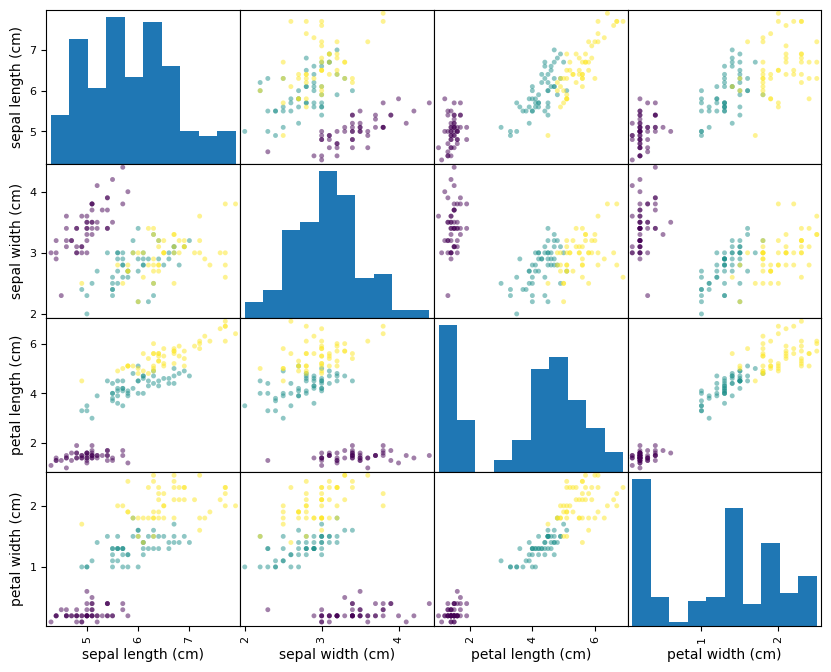

In [ ]:
pd.plotting.scatter_matrix( # cross sectional scatter plots of each pair of feature variables
    frame=df.iloc[:,0:4], # the first four columns in the dataframe
    c=df['label (species)'],
    figsize=(10,8),
    **{'s':50.0} # extra key-word arguments
)
plt.show()

## Implementing the Gaussian Naïve Bayes Classifier

Next, we are going to implement a `GaussianNaiveBayes` class which will allow us to fit a Gaussian Naïve Bayes (GNB) classifier and make predictions with it. I am also going to take this opportunity to illustrate the LaTeX/MathTeX capabilities of Google Colab notebooks - [read this notebook](https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb) for an introduction to writing LateX in Colab.  

As a reminder, our classifier needs to be able to take as input a real-valued matrix $X \in {\rm I\!R}^{n\times m}$, where $n$ is the number of samples/instances and $m$ is the number of features, as well as a label vector $y\in \{0,1,2,\dots k\}^n$, fit the GNB classifier (computing the means and standard deviations for each feature given each class) and then classify a new sample $\mathbf{x} \in {\rm I\!R}^m$ according to:

\begin{align}
  \text{class}(x) &= arg \max_{c}p(c|\mathbf{x}) \\
  &= arg \max_{c} \log(\prod_{j=1}^mp(x_j| c)p(c)) \\
\end{align}

where $c \in \{0,1,2,\dots k\}$ corresponds to a particular class, and where $p(x_j | c) \propto f(x_j; \mu_{j,c}, \sigma_{j,c})$, which is the probability density function (PDF) of the gaussian distribution parameterised by the mean and standard deviation beloinging to a speficic feature variable in a specific class ($j,c$ indicates the $j^{th}$ feature of the $c^{th}$ class) - this is what we compute in practice.

A few notes on the code, which I will leave up to you to examine in detail:

*   The `GaussianNaiveBayes` class has two functions which are meant to be accessed by the user: the `fit()` function, and the `predict()` function. This is a standard design pattern for machine learning classes which is pretty ubiquitous in python machine learning libraries (SK-learn, Pytorch, TensorFlow etc.) - we encourage you to structure your classes this way when you implement ML models of your own in this course.
*   Note that the "helper" functions, which are only meant to be accesed by other functions within the class, start with an underscore (e.g. `_gaussian_pdf()`)
*   Function names are all lowercase, separated by underscores, and class names are written in camel case (aka words are not separated, but the first letter of each word is capitalised)


In [ ]:
# Implement the Gaussian Naïve Bayes classifier
# Source: 'Machine Learning From Scratch' (https://www.youtube.com/watch?v=rLOyrWV8gmA)
class GaussianNaiveBayes: # a python class
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate log posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx]) # log of prior
            posterior = np.sum(np.log(self._gaussian_pdf(idx, x))) + prior # log of posterior
            posteriors.append(posterior)

        # return class with highest log posterior probability
        return self._classes[np.argmax(posteriors)]

    def _gaussian_pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

## Feature selection & splitting the data into a train and test set

Next, we are going to select the features we'd like to use to train our model. Normally you would do some testing and experimentation to get this right, but I am just going to choose 'sepal length' and 'petal width' arbitrarily - having only two features also means we can visualise the data easily.

Our last step before training is going to be splitting our data into two sets, one for training/fitting the classifier and the other for testing it's performance after it's been trained. I've implemented a `train_test_split()` function so you can see how this is done.

In [ ]:
# Choose features 'sepal length' and 'petal width'
X, y = df[['sepal length (cm)', 'petal width (cm)']].values, df['label (species)'].values

# Splitting the data into a training and testing set, having an 80/20 split
def train_test_split(X, y, test_proportion, random_seed=30):
  np.random.seed(random_seed)
  n_samples = y.shape[0]
  sample_indices = np.arange(n_samples)
  np.random.shuffle(sample_indices)
  train_indices = sample_indices[int(n_samples * test_proportion):]
  test_indices = sample_indices[:int(n_samples * test_proportion)]

  return X[train_indices], y[train_indices], X[test_indices], y[test_indices]

X_train, y_train, X_test, y_test = train_test_split(X, y, test_proportion=0.2)

## Fit the Gaussian Naïve Bayes model and print the accuracy on the train and test sets

The simplest evaluation metric for classifiers is accuracy, which is simply "the percentage instances classified correctly", which is what we will use to evaluate our model. Notice that the accuracy on the train set is a little better than on the test set, this will more often than not be the case since the test data is data which the model has not "seen" during training.  

In [ ]:
# fit the classifier and print the train and test accuracy
clf = GaussianNaiveBayes()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
train_accuracy = sum(np.equal(y_train_pred, y_train))/y_train.shape[0]

y_test_pred = clf.predict(X_test)
test_accuracy = sum(np.equal(y_test_pred, y_test))/y_test.shape[0]

print(f"Classifier accuracy on train set: {100 * round(train_accuracy,2)}%")
print(f"Classifier accuracy on test set: {100 * round(test_accuracy,2)}%")

Classifier accuracy on train set: 97.0%
Classifier accuracy on test set: 93.0%


## Plotting the decision regions of our classifier over our train and test sets

To visualise our trained GNB classifier, we can use matplotlibs `contourf()` function to make a contour plot of the difference decision regions. All the yellow, blue and purple points which fall into the yellow, blue and purple regions, respectively, are correctly classified, and those which don't are incorrectly classified.  

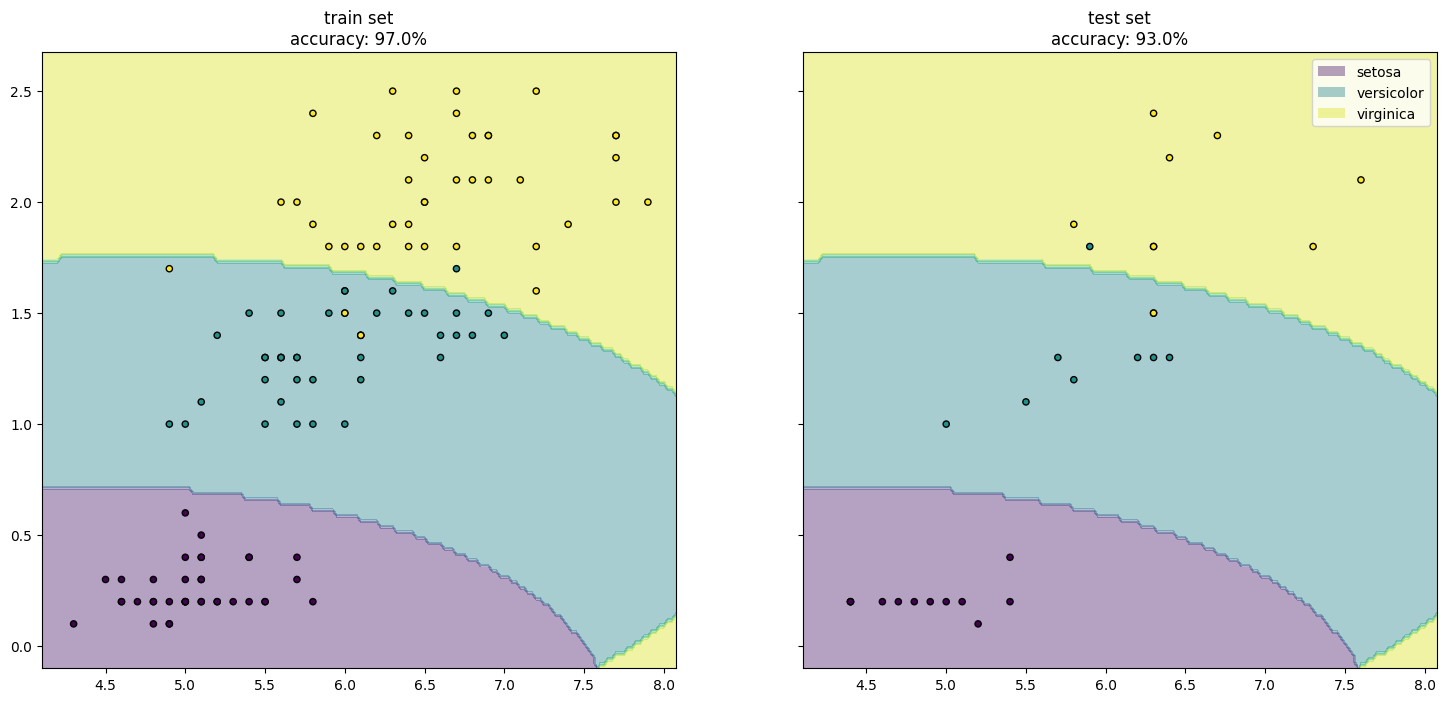

In [ ]:
 # Plotting decision regions
x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.025),
                         np.arange(x2_min, x2_max, 0.025))

f, axarr = plt.subplots(1, 2, sharey='row', figsize=(18, 8))

Z = clf.predict(np.c_[x1x1.ravel(), x2x2.ravel()])
Z = Z.reshape(x1x1.shape)

cs=axarr[0].contourf(x1x1, x2x2, Z, alpha=0.4)
axarr[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k')
axarr[0].set_title(f"train set\naccuracy: {100 * round(train_accuracy,2)}%")

axarr[1].contourf(x1x1, x2x2, Z, alpha=0.4)
axarr[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
axarr[1].set_title(f"test set\naccuracy: {100 * round(test_accuracy,2)}%")

colors = [cs.legend_elements()[0][i] for i in [0,3,7]]
plt.legend(colors, iris.target_names)
plt.show()